### ©Lucas Chizzali, New York University, Center for Urban Science and Progress

#### Importing relevant modules

In [122]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pylab as plt
%pylab inline
import numpy as np
import geopandas as gpd
import requests, zipfile, StringIO
import re
import multiprocessing as mp
import mplleaflet
import statsmodels.formula.api as smf
import scipy.stats as scs
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Contents
### 1. Data Wrangling
### 2. Analysis of Sales Data
### 3. Merging with Assessment Data from DOF
### 4. Working with Outliers
### 5. Analysis of Tax Data
### 6. Timeanalysis of Tax Data
### 7. Analysis of Effective Tax Rates
    - Across Zip Codes
    - Calculation of Tax Burden
    - Across Tax Classes
    - Across Building Classes
### 8. Analysis of PUMA data
### 9. Analysis of Zillow data
### 10. Further Visualizations

### 1. Data Wrangling

In [2]:
# Read in additional files
url_zip = 'https://www.dropbox.com/sh/nlbj8whi5izbihr/AAD8CvKIYMnVpKUcBDazRe22a?dl=1'
r = requests.get(url_zip)
zip_ = zipfile.ZipFile(StringIO.StringIO(r.content))
filename_zip = 'ZIP_spatial/Zip_code/ZIP_CODE_040114.shp'
filename_tax = 'Tax_rates.csv'
filename_files = 'Files.csv'
filename_income = 'ACS_14_5YR_S1903_with_ann.csv'

In [3]:
# urls to the data
files = pd.read_csv(zip_.open(filename_files))
files.head(2)

,Filenames_Links
0,http://www1.nyc.gov/assets/finance/downloads/p...
1,http://www1.nyc.gov/assets/finance/downloads/p...


In [4]:
# Create three lists
list_sales_detail = list(files['Filenames_Links'][:5])
older_list = list(files['Filenames_Links'][5:20])
even_older_list = list(files['Filenames_Links'][20:])

In [5]:
# Read in zip code shapes for plotting
zipcodes = gpd.GeoDataFrame.from_file(filename_zip)#zip_.open(filename)) # Does not work...
zipcodes = zipcodes[['ZIPCODE','geometry']]
zipcodes.ZIPCODE = zipcodes.ZIPCODE.astype(int)
zipcodes.rename(columns={'ZIPCODE':'ZIP_CODE'},inplace=True)

In [6]:
# Add tax rate information
tax = pd.read_csv(zip_.open(filename_tax))
tax = tax.convert_objects(convert_numeric=True)
filename_assessment = 'dof_assessments_merged.csv'

In [7]:
# Reading newer data
# Create empty dataframe to store values
sales_detail_recent = pd.DataFrame()
for url in list_sales_detail:
    xl_data = pd.read_excel(url, header=4)
    xl_data.columns = xl_data.columns.map(lambda x: x.rstrip('\n').replace(' ','_'))
    sales_detail_recent = sales_detail_recent.append(xl_data)

In [8]:
# Reading older data
sales_detail_old = pd.DataFrame()
for url in older_list:
    xl_data = pd.read_excel(url, header=4)
    xl_data.columns = xl_data.columns.map(lambda x: x.rstrip('\n').replace(' ','_'))
    sales_detail_old = sales_detail_old.append(xl_data)

In [9]:
# Reading even older data
sales_detail_older = pd.DataFrame()
for url in even_older_list:
    xl_data = pd.read_excel(url, header=3)
    xl_data.columns = xl_data.columns.map(lambda x: x.rstrip('\n').replace(' ','_'))
    sales_detail_older = sales_detail_older.append(xl_data)

In [10]:
# Create a subset
def subset(df):
    df = df[(df.TAX_CLASS_AT_TIME_OF_SALE<3)&(df.SALE_PRICE>100000)&
        (df.BUILDING_CLASS_CATEGORY != '05  TAX CLASS 1 VACANT LAND')]
    return df

In [11]:
# Prepare datasets before joining
recent_data = subset(sales_detail_recent)
old_data = subset(sales_detail_old)
older_data = subset(sales_detail_older)

In [12]:
data = recent_data.append([old_data,older_data],ignore_index=True)

In [13]:
data.APARTMENT_NUMBER = data.APARTMENT_NUMBER.apply(lambda x: str(x).encode('ascii','ignore'))
data.APARTMENT_NUMBER = data.APARTMENT_NUMBER.apply(lambda x: x.strip().replace(' ','-'))
data.BUILDING_CLASS_CATEGORY = data.BUILDING_CLASS_CATEGORY.apply(lambda x: str(x).encode('ascii','ignore'))
data.BUILDING_CLASS_CATEGORY = data.BUILDING_CLASS_CATEGORY.apply(lambda x: x.strip())

In [14]:
def nestCode(b, block, lot):
    return ''.join((b,  '0'*(5-len(block)),  block,  '0'*(4 - len(lot)),  lot))

#### Bins should be based on a per unit basis to account for apartment and building sales

In [15]:
# Approximate the value of each unit within the building sold
# If there are no residential units in the building, the sale_price_unit is just the sale_price
data['SALE_PRICE_UNIT'] = np.where(data['RESIDENTIAL_UNITS']==0,data.SALE_PRICE, 
                                   (data.SALE_PRICE/data.RESIDENTIAL_UNITS))

In [16]:
data['SALE_YEAR'] = data.SALE_DATE.map(lambda x: x.year)

# Round and convert to integer
data['SALE_PRICE_UNIT'] = np.around(data['SALE_PRICE_UNIT'],decimals=0)
data['SALE_PRICE_UNIT'] = data['SALE_PRICE_UNIT'].astype(int)

# Create BBL
data[['BOROUGH','BLOCK','LOT']] = data[['BOROUGH','BLOCK','LOT']].astype(str)
data['BBL'] = data.apply(lambda x: nestCode(x.BOROUGH, x.BLOCK, x.LOT), 1)

# Create bins
bins = [0,200000,400000,600000,800000,1000000,1500000,3000000,6000000,
        10000000,max(data.SALE_PRICE_UNIT)]
labels = np.arange(1,11,1)
data['PRICE_BINS'] = pd.cut(data.SALE_PRICE,bins,labels=labels)
data['PRICE_UNIT_BINS'] = pd.cut(data.SALE_PRICE_UNIT,bins,labels=labels)

# Ticks corresponding to bins
x_ticks = ['$(0-200k]','$(200k-400k]','$(400k-600k]','$(600k-800k]','$(800k-1m]',
           '$(1m-1.5m]','$(1.5m-3m]','$(3m-6m]','$(6m-10m]','$(10m-~170.5m]']

In [17]:
data.columns

Index([                       u'BOROUGH',                   u'NEIGHBORHOOD',
              u'BUILDING_CLASS_CATEGORY',           u'TAX_CLASS_AT_PRESENT',
                                u'BLOCK',                            u'LOT',
                            u'EASE-MENT',      u'BUILDING_CLASS_AT_PRESENT',
                              u'ADDRESS',               u'APARTMENT_NUMBER',
                             u'ZIP_CODE',              u'RESIDENTIAL_UNITS',
                     u'COMMERCIAL_UNITS',                    u'TOTAL_UNITS',
                     u'LAND_SQUARE_FEET',              u'GROSS_SQUARE_FEET',
                           u'YEAR_BUILT',      u'TAX_CLASS_AT_TIME_OF_SALE',
       u'BUILDING_CLASS_AT_TIME_OF_SALE',                     u'SALE_PRICE',
                            u'SALE_DATE',                u'SALE_PRICE_UNIT',
                            u'SALE_YEAR',                            u'BBL',
                           u'PRICE_BINS',                u'PRICE_UNIT_BINS']

In [18]:
# Select only relevant columns
data = data[['ZIP_CODE','SALE_DATE','SALE_YEAR','PRICE_BINS',
             'TAX_CLASS_AT_PRESENT','APARTMENT_NUMBER',
             'RESIDENTIAL_UNITS','TAX_CLASS_AT_TIME_OF_SALE',
             'SALE_PRICE','SALE_PRICE_UNIT','BBL','RESIDENTIAL_UNITS',
             'TOTAL_UNITS','LAND_SQUARE_FEET','PRICE_UNIT_BINS',
             'BUILDING_CLASS_AT_TIME_OF_SALE','YEAR_BUILT','BUILDING_CLASS_CATEGORY']]

In [19]:
tax # Output tax rates for visualization

,YEAR,CLASS 1,CLASS 2,CLASS 3,CLASS 4
0,2015,0.20,0.13,0.11,0.11
1,2014,0.19,0.13,0.11,0.11
2,2013,0.19,0.13,0.12,0.10
3,2012,0.19,0.13,0.12,0.10
4,2011,0.18,0.13,0.12,0.10
5,2010,0.17,0.13,0.13,0.10
6,2009,0.17,0.13,0.13,0.10
7,2008,0.16,0.13,0.12,0.10
8,2007,0.15,0.12,0.12,0.10


In [20]:
# Adding tax rates to datasets
def tax_rate(df,year):
    pos = tax[tax['YEAR'] == year].index.tolist()[0]
    df['TAX_RATE'] = np.where(df['TAX_CLASS_AT_TIME_OF_SALE']==1,
                              tax.iloc[pos,1],tax.iloc[pos,2])
    return df

In [21]:
headers = data.columns # Store headers

In [22]:
# Apply function to get tax rates
# Faster than an if statement within a loop
y2014 = data[data['SALE_YEAR']==2014]
y2013 = data[data['SALE_YEAR']==2013]
y2012 = data[data['SALE_YEAR']==2012]
y2011 = data[data['SALE_YEAR']==2011]
y2010 = data[data['SALE_YEAR']==2010]
y2009 = data[data['SALE_YEAR']==2009]
y2008 = data[data['SALE_YEAR']==2008]

y2008 = tax_rate(y2008,2008)
y2009 = tax_rate(y2009,2009)
y2010 = tax_rate(y2010,2010)
y2011 = tax_rate(y2011,2011)
y2012 = tax_rate(y2012,2012)
y2013 = tax_rate(y2013,2013)
y2014 = tax_rate(y2014,2014)

In [23]:
# Reunite data, use numpy because pandas is raising axis error
final = pd.DataFrame(np.concatenate([y2008,y2009,y2010,y2011,y2012,y2013,y2014]))
final.columns = headers.insert(len(headers), 'TAX_RATE')
final = final.convert_objects(convert_dates=True,convert_numeric=True)

### 2. Analysis of Estate Sales

In [24]:
# Get counts of the different bins, faster than conventional histogram
count = {}
for i in final['PRICE_BINS']:
    count[i] = count.get(i, 0) + 1   

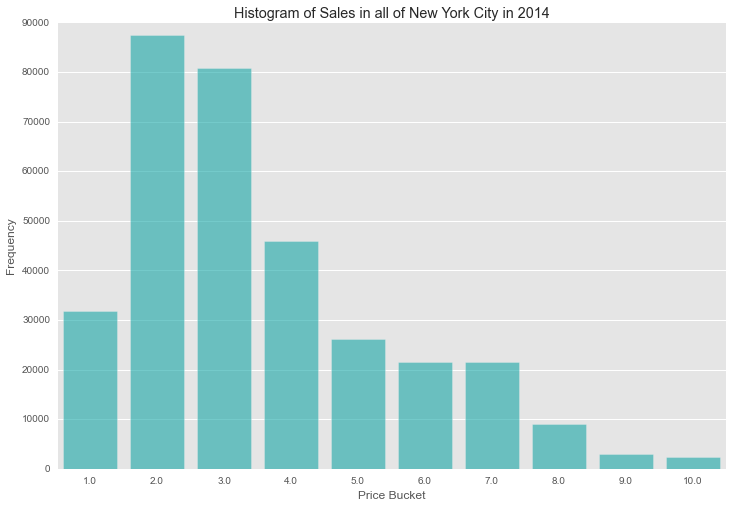

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
df = pd.DataFrame.from_dict(count, 'index')
sns.barplot(x=df.index,y=df[0],color='c',alpha=0.6)
plt.title('Histogram of Sales in all of New York City in 2014')
plt.ylabel('Frequency')
plt.xlabel('Price Bucket')
ax.xaxis.get_majorticklocs()
#ax.xaxis.set_ticks(x_ticks)
#plt.xticks([i for i in labels],[str(w) for w in x_ticks]) 
del df

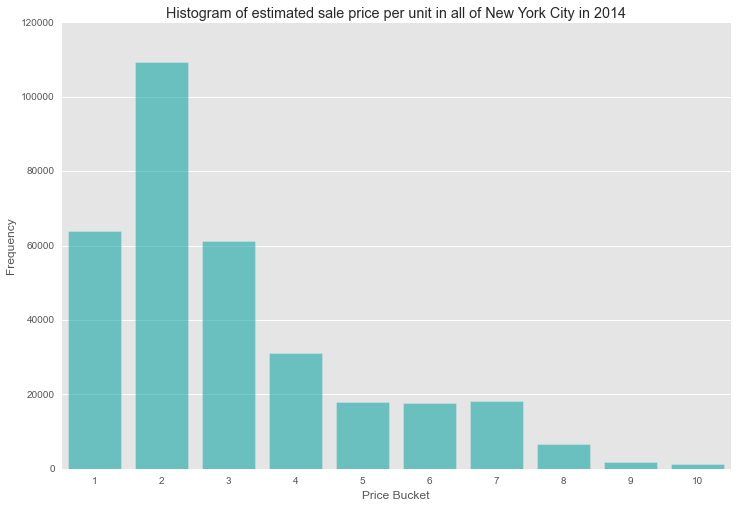

In [26]:
# Get counts of the different bins, faster than conventional histogram
count = {}
for i in final['PRICE_UNIT_BINS']:
    count[i] = count.get(i, 0) + 1  
    
fig, ax = plt.subplots(figsize=(12,8))
df = pd.DataFrame.from_dict(count, 'index')
sns.barplot(x=df.index,y=df[0],color='c',alpha=0.6)
plt.title('Histogram of estimated sale price per unit in all of New York City in 2014')
plt.ylabel('Frequency')
plt.xlabel('Price Bucket')
ax.xaxis.get_majorticklocs()
del df

In [27]:
final = final.merge(zipcodes,on='ZIP_CODE',how='inner')
final = gpd.GeoDataFrame(final) # For plotting

### Estimate price increase from 2009 to 2014 in percentage terms

In [28]:
# From Zillow
# http://www.zillow.com/new-york-ny/home-values/
(562-457)/457.0

0.22975929978118162

In [29]:
# From the data
((np.mean(final[final['SALE_YEAR']==2014]['SALE_PRICE_UNIT'])-
 np.mean(final[final['SALE_YEAR']==2009]['SALE_PRICE_UNIT']))/
 np.mean(final[final['SALE_YEAR']==2009]['SALE_PRICE_UNIT']))

0.3088979300819252

### 3. Merging with Assessment Data from DOF
### Get Assessment data from DOF in order to compute effective tax rate (ETR)

In [30]:
assessment09 = pd.read_csv('ZIP_spatial/dof_assessment/dof_assessments_merged_09.csv')
assessment10 = pd.read_csv('ZIP_spatial/dof_assessment/dof_assessments_merged_10.csv')
assessment11 = pd.read_csv('ZIP_spatial/dof_assessment/dof_assessments_merged_11.csv')
assessment12 = pd.read_csv('ZIP_spatial/dof_assessment/dof_assessments_merged_12.csv')
assessment13 = pd.read_csv('ZIP_spatial/dof_assessment/dof_assessments_merged_13.csv')
assessment14 = pd.read_csv('ZIP_spatial/dof_assessment/dof_assessments_merged_14.csv')
assessment15 = pd.read_csv('ZIP_spatial/dof_assessment/dof_assessments_merged_15.csv')

In [31]:
final.BBL = final.BBL.astype(str)

In [32]:
def prepare(x,y):
    del x['Unnamed: 0'] # Delete unnecessary columns
    x.rename(columns={'BBLE':'BBL'},inplace=True)
    # Make sure BBL is same type for merging
    x.BBL = x.BBL.astype(str)
    y = y.merge(x,on='BBL',how='inner')
    return y

In [33]:
# Break final back into the different sales years to merge with correct tax final
y2014 = final[final['SALE_YEAR']==2014]
y2013 = final[final['SALE_YEAR']==2013]
y2012 = final[final['SALE_YEAR']==2012]
y2011 = final[final['SALE_YEAR']==2011]
y2010 = final[final['SALE_YEAR']==2010]
y2009 = final[final['SALE_YEAR']==2009]
y2008 = final[final['SALE_YEAR']==2008]

In [34]:
# DOF data of a given year is for previous year
df2014 = prepare(assessment15,y2014)
df2013 = prepare(assessment14,y2013)
df2012 = prepare(assessment13,y2012)
df2011 = prepare(assessment12,y2011)
df2010 = prepare(assessment11,y2010)
df2009 = prepare(assessment10,y2009)
df2008 = prepare(assessment09,y2008)

In [35]:
headers = df2014.columns 
# Reunite data, use numpy because pandas is raising axis error
finale = pd.DataFrame(np.concatenate([df2008,df2009,df2010,df2011,df2012,df2013,df2014]))
finale.columns = headers
finale = finale.convert_objects(convert_dates=True,convert_numeric=True)

***MARKET VALUES***
- CUR_FV_T = AV-CUR-FULLVAL-TOTAL : If not zero, Current year’s total market value

***ASSESSED VALUES ( ACTUAL & TRANSITIONAL )*** : Contains the Assessed Values for the current fiscal year
- CUREXT = AV-CUREXT : Current Transitional Exempt Total Value
- CUREXT_A = AV-CUREXT-ACT : Current Actual Exempt Total Value
- CURAVT = AV-CURAVT : Current Transitional Assessed Total Value
- CURAVT_A = AV-CURAVT-ACT : Current Actual Assessed Total Value

***FINAL ASSESSED VALUES***
- FN_EXT = AV-FINAL-EXT : Final Transitional Exempt Total Value


### NOTES:
The law requires that the DOF uses whichever number is lower – the actual assessed value or transitional assessed value – to get to your property tax bill.
Your Assessed Value is based on a percentage of your Market Value. This percentage is known as the Level of Assessment or Assessment Ratio. Your Assessment Ratio depends on your tax class.

|Assessment Ratios|Percentage|
|:---------------:|:--------:|
|Tax class 1|	                6%|
|Tax class 2, 3 and 4 |   	45%|

***Transitional***

The DOF phases in changes to the assessed value of Class 2 properties with more than 10 units and Class 4 properties over a five-year period. This means that it applies 20% of the change each year for five years. 

#### Using DOF's Current Year Market Value as an approximation for market value. Using current actual exempt value.
One can do this using final values as well.

In [36]:
# Whole building
finale['TAXABLE_ACTUAL'] = finale['CURAVT_A'] - finale['CUREXT_A']
finale['TAX_PAID'] = finale.TAXABLE_ACTUAL * finale.TAX_RATE
finale['ETR_DOF'] = np.round((finale['TAX_PAID']/finale['CUR_FV_T'])*100,2) # Market value from DOF

#### Computing the ETR on an apartment level

In [37]:
# RESIDENTIAL UNITS is for some reason a multi-index column
l = np.array(finale['RESIDENTIAL_UNITS'].apply(lambda x: x))
l = l[:,0]
del finale['RESIDENTIAL_UNITS']
finale['RESIDENTIAL_UNITS'] = l

In [38]:
print ((len(finale['TOTAL_UNITS'])-list(finale['TOTAL_UNITS']==finale['TOT_UNIT']).count(True))/
        np.float(len(finale))*100)

37.1236869388


***38% of the total units info from the sales data does not match with the units info from assessment data.
Hence we pick assessment data from now on, since this is the information that is considered when paying taxes and thus assumed to be more likely to represent reality.***

In [39]:
# Calculating the number of units
# Total units in building
finale['TAX_UNIT'] = np.where(finale['TOT_UNIT']==0,1,finale['TOT_UNIT'])
# Number of units sold out of total, use sales data because it tells one how many apartments are included in the price
finale['SALE_UNIT'] = np.where(finale['RESIDENTIAL_UNITS']==0,1,finale['RESIDENTIAL_UNITS'])

In [40]:
# Estimate tax rate per unit
# Use AV-TOTAL-UNITS instead of TAX_UNITS, which is f(TOTAL_UNITS)
# because sales data is unreliable with regard to total units
# TAX_PAID is for the whole building, thus dividing by TAX_UNIT gives us a proxy for the taxes paid by each residential
# unit. To get the final effective tax rate, one divides by the sale price adjusted for whether an apartment was sold
# or the whole building.
finale['ETR_ACTUAL_UNIT'] = np.round((finale.TAX_PAID/finale['TAX_UNIT'])/
                                       (finale.SALE_PRICE/finale['SALE_UNIT']),4)*100

# Alternative to ETR_ACTUAL_UNIT
#finale['ETR_ACTUAL'] = np.where(((finale.SALE_PRICE/finale['SALE_UNIT'])*finale['TOT_UNIT'])==0,np.nan,
#                        np.round((finale.TAX_PAID/
#                    ((finale.SALE_PRICE/finale['SALE_UNIT'])*finale['TOT_UNIT'])),4)*100)

## DOF data is already on a unit basis
#finale['ETR_DOF_UNIT'] = np.round(((finale['TAX_PAID']/finale['TAX_UNIT'])/
#                                   (finale['CUR_FV_T']/finale['TAX_UNIT']))*100,2)

### 4. Working with Outliers

#### Looking at outliers

In [41]:
# Some data is inconsitent.
# For example here, 102 units are sold for $2,600,000 while the whole building has 105 units
# and paid $2,969,769 in taxes. Thus, the tax rate is higher than 100 Percent...
finale[finale['ETR_ACTUAL_UNIT']>100][['SALE_PRICE','TAX_UNIT','TOT_UNIT',
                                           'RES_UNIT','SALE_UNIT','TAX_PAID','ETR_ACTUAL_UNIT','BBL',
                                         'RESIDENTIAL_UNITS','CURAVT_A','CUREXT_A',
                                         'TOTAL_UNITS','APARTMENT_NUMBER']][:5]

,SALE_PRICE,TAX_UNIT,TOT_UNIT,RES_UNIT,SALE_UNIT,TAX_PAID,ETR_ACTUAL_UNIT,BBL,RESIDENTIAL_UNITS,CURAVT_A,CUREXT_A,TOTAL_UNITS,APARTMENT_NUMBER
842,385000,196,196,196,196,1130098.06,293.53,1007691104,196,8820000,126938,196,NaN
4502,850000,144,144,144,144,922371.19,108.51,1005601003,144,7245000,149837,144,3
4527,453000,229,229,229,229,1432268.50,316.17,1005611003,229,11205000,187550,229,NaN
4960,460000,62,62,62,62,527959.64,114.77,1008820052,62,4158000,96772,62,NaN
5236,395000,243,243,236,236,1927252.08,473.86,1008900001,236,14985000,159984,243,NaN


In [42]:
finale[finale['BBL']==4084890001][:5]

,ZIP_CODE,SALE_DATE,SALE_YEAR,PRICE_BINS,TAX_CLASS_AT_PRESENT,APARTMENT_NUMBER,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_PRICE_UNIT,BBL,...,FN_AVT,FN_EXT,TXCL,TAXABLE_ACTUAL,TAX_PAID,ETR_DOF,RESIDENTIAL_UNITS,TAX_UNIT,SALE_UNIT,ETR_ACTUAL_UNIT
35238,11005,2008-01-14,2008,3,2,NaN,2,500000,500000,4084890001,...,127004398,12171538,2,119697025,15560613.25,5.31,0,1866,1,1.67
35239,11005,2008-01-09,2008,2,2,NaN,2,275000,275000,4084890001,...,127004398,12171538,2,119697025,15560613.25,5.31,0,1866,1,3.03
35240,11005,2008-01-10,2008,3,2,NaN,2,445000,445000,4084890001,...,127004398,12171538,2,119697025,15560613.25,5.31,0,1866,1,1.87
35241,11005,2008-02-14,2008,2,2,NaN,2,290000,290000,4084890001,...,127004398,12171538,2,119697025,15560613.25,5.31,0,1866,1,2.88
35242,11005,2008-02-29,2008,3,2,NaN,2,536496,536496,4084890001,...,127004398,12171538,2,119697025,15560613.25,5.31,0,1866,1,1.55


In [43]:
# Some buildings are not paying taxes at all
finale[finale['ETR_DOF']==0][['TAX_PAID','CURAVT_A','TAX_RATE','CUREXT_A']].head()

,TAX_PAID,CURAVT_A,TAX_RATE,CUREXT_A
1330,0,7875000,0.13,7875000
1331,0,7875000,0.13,7875000
1332,0,7875000,0.13,7875000
1333,0,7875000,0.13,7875000
1381,0,1467000,0.13,1467000


#### Clean the data

In [44]:
print len(finale[(finale['ETR_ACTUAL_UNIT']>20)|(finale['ETR_DOF']==0)|(finale['ETR_ACTUAL_UNIT']>20)]) # observations are outliers...

2876


In [45]:
finale = finale[(finale['ETR_ACTUAL_UNIT']<20)&(finale['ETR_DOF']!=0)&(finale['ETR_ACTUAL_UNIT']<20)]

### 5. Analysis of Tax Data
#### Compare Tax Rates

In [46]:
taxrates = pd.DataFrame({'ETR_ACTUAL_MEAN':finale.groupby('PRICE_UNIT_BINS',axis=0)['ETR_ACTUAL_UNIT'].mean(),
                            'ETR_ACTUAL_MEDIAN':finale.groupby('PRICE_UNIT_BINS',axis=0)['ETR_ACTUAL_UNIT'].median(),
                            'ETR_DOF_MEAN':finale.groupby('PRICE_UNIT_BINS',axis=0)['ETR_DOF'].mean(),
                        'ETR_DOF_MEDIAN':finale.groupby('PRICE_UNIT_BINS',axis=0)['ETR_DOF'].median()}).reset_index()

In [47]:
taxrates

,PRICE_UNIT_BINS,ETR_ACTUAL_MEAN,ETR_ACTUAL_MEDIAN,ETR_DOF_MEAN,ETR_DOF_MEDIAN
0,1,1.433736,1.22,3.151049,3.90
1,2,0.914272,0.80,3.019811,1.93
2,3,0.813064,0.70,3.048099,1.64
3,4,0.786329,0.73,3.468048,5.40
4,5,0.765016,0.74,3.862423,5.66
5,6,0.698273,0.69,4.190849,5.70
6,7,0.594354,0.57,4.347431,5.74
7,8,0.459789,0.44,4.459669,5.78
8,9,0.337159,0.33,4.271320,5.78
9,10,0.238179,0.21,4.059275,5.78


CPU times: user 25.9 s, sys: 392 ms, total: 26.3 s
Wall time: 26.4 s


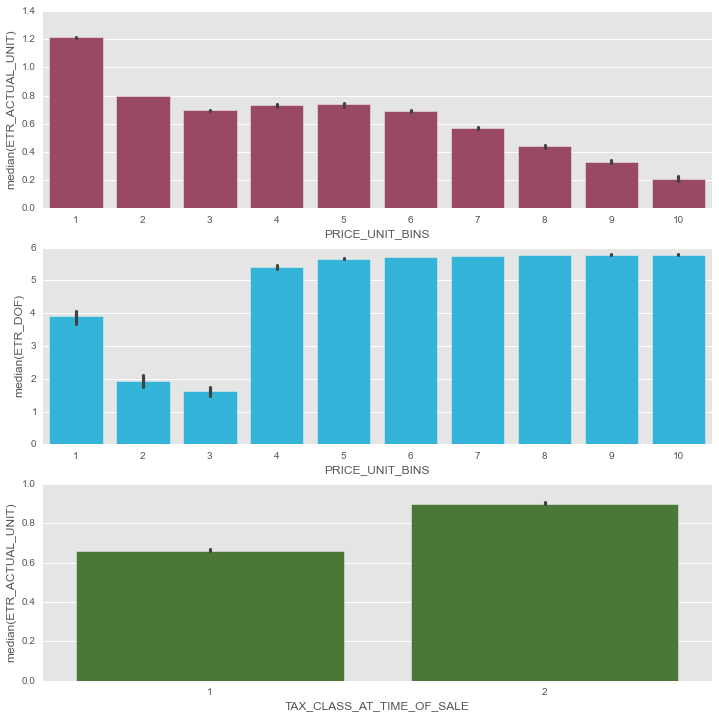

In [48]:
%%time
# Use all processors
pool = mp.Pool()
# Visualize it
from numpy import median, mean
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=False)
sns.barplot(x='PRICE_UNIT_BINS', y='ETR_ACTUAL_UNIT', data=finale, estimator=median, ax=ax1, color='#AA385E', saturation=0.7, 
            order=[1,2,3,4,5,6,7,8,9,10])
sns.barplot(x='PRICE_UNIT_BINS', y='ETR_DOF', data=finale, estimator=median, ax=ax2, color='#12C7FD', saturation=0.7,
           order=[1,2,3,4,5,6,7,8,9,10])
sns.barplot(x='TAX_CLASS_AT_TIME_OF_SALE', y='ETR_ACTUAL_UNIT', data=finale, estimator=median, ax=ax3, color='#45842B', 
            saturation=0.7)

*** The way DOF assesses market values is counter the actual market evaluation of property, especially for estate in price bins above 5. This essentially creates inequality as more expensive estates pay less tax.***

CPU times: user 421 ms, sys: 244 ms, total: 665 ms
Wall time: 668 ms


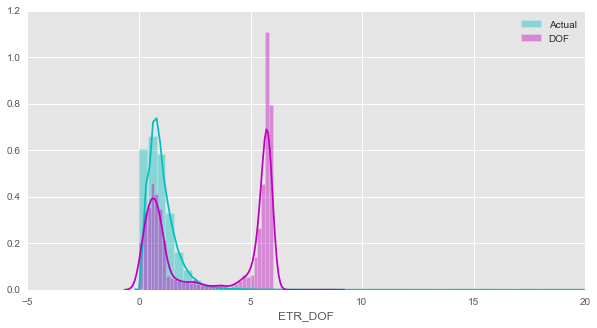

In [49]:
%%time
# Use all processors
pool = mp.Pool()
plt.figure(figsize=(10,5))
sns.distplot(finale.ETR_ACTUAL_UNIT.dropna(),color='c',label='Actual')
sns.distplot(finale.ETR_DOF.dropna(),color='m',label='DOF')
plt.legend()

In [50]:
# Create new index, since old is not coherent anymore after cleaning data
finale = finale.reset_index()
del finale['index']

CPU times: user 4.39 s, sys: 611 ms, total: 5 s
Wall time: 4.7 s


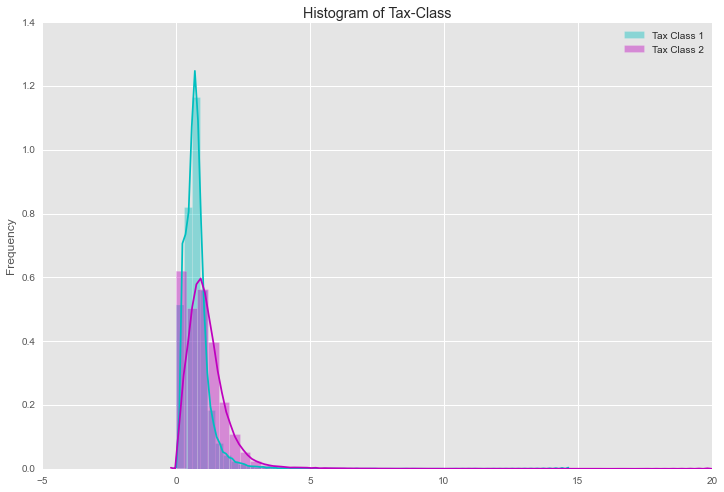

In [51]:
%%time
# Use all processors
pool = mp.Pool()
# Get counts of the different bins, faster than conventional histogram
ETR_1 = []
ETR_2 = []
for i,l in enumerate(finale['TAX_CLASS_AT_PRESENT']):
    if str(l).find('1')!=-1:
        ETR_1.append(finale['ETR_ACTUAL_UNIT'][i])
    elif str(l).find('2')!=1:    
        ETR_2.append(finale['ETR_ACTUAL_UNIT'][i])
ETR_1 = pd.Series(ETR_1)
ETR_2 = pd.Series(ETR_2)
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(ETR_1.dropna(),color='c', label='Tax Class 1')
sns.distplot(ETR_2.dropna(),color='m',label='Tax Class 2')
plt.title('Histogram of Tax-Class')
plt.ylabel('Frequency')
plt.legend()
ax.xaxis.get_majorticklocs();

#### Data appears to be normally distributed, although heavily skewed.

##### Hypothesis
The research question's aim is to see whether residents of tax class 2 property pay more in ETR than residents of tax class 1 property.

$H_0: \mu_1=\mu_2$

$H_1: \mu_1\neq\mu_2 $

At $\alpha=0.05$

Now we analyze the dataset in terms of standard deviation and other important moments in order to compute the t-statistic. We consider the 2014 sample to be a sample for all estates in New York City. We compare two means, thus we apply the formula for the Welch's t-test:
<br>
<br>
<br>
$t=\frac{\mu_1-\mu_2}{\sqrt{\frac{s_{1}^2}{n_1}+\frac{s_{2}^2}{n_2}}}$
<br>
<br>
<br>
We make use of the Central Limit Theorem and assume that due to the large sample size, the data can be approximated by a normal distribution, eventhough the normal test shows that the sample does not behave normally distributed even after cleaning and adjusting for the skewness.

In [52]:
# Clean data
def clean(x):
    x = pd.Series(x)
    x = x[x>0].dropna()
    return x

ETR_1 = clean(ETR_1)
ETR_2 = clean(ETR_2)


import scipy
print scipy.stats.mstats.normaltest(ETR_1.apply(lambda x: np.log(x)))
print scipy.stats.mstats.normaltest(ETR_2.apply(lambda x: np.log(x)))

# Getting standard deviation for each usertype and other moments:
def parameters(x):
    mean = x.mean()
    std = x.std()
    count = x.count()
    return mean,std,count

m1,s1,n1 = parameters(ETR_1)
m2,s2,n2 = parameters(ETR_2)

# Compute the t-stat:
t = (m1 - m2)/math.sqrt((s1**2/n1)+(s2**2/n2))
print t

print n1,n2

(16084.737997419503, 0.0)
(51202.383659987187, 0.0)
-119.027921409
70227 163206


The degrees of freedom (df) is bigger is defined as n-1. For both samples, df is > 120. For an $\alpha$ of 5%, the critical t-value for df$\approx\inf$ is 1.960. Thus, our t-value exceeds the critical value. 

***Conclusion***

Based on the critical value and p-value we reject $H_0$ and can say that Tax class 1 residents pay on average a different amount than tax class 2 residents.

### Pearson Test
Measures the degree and direction of a possible linear relationship between two datasets. The output includes the correlation coefficient and the p-value for testing noncorrelation:

$H_0$: Samples are not correlated

$H_1$: Samples are correlated

For an $\alpha$ of 5%, we reject $H_0$ if the p-value is below that threshold

In [123]:
print 'Price Unit Bins ~ ETR'
print 'Pearson correlation coefficient:',scs.pearsonr(finale.PRICE_UNIT_BINS, finale.ETR_ACTUAL_UNIT)[0]
print 'p-value:',scs.pearsonr(finale.PRICE_UNIT_BINS, finale.ETR_ACTUAL_UNIT)[1]
print 'Are the samples of the same size?',len(finale.PRICE_UNIT_BINS)==len(finale.ETR_ACTUAL_UNIT)
print '--------------------------------------------'
print 'Sale Price Unit ~ ETR'
# Actual raw sales finale
print 'Pearson correlation coefficient:',scs.pearsonr(finale.SALE_PRICE_UNIT, finale.ETR_ACTUAL_UNIT)[0]
print 'p-value:',scs.pearsonr(finale.SALE_PRICE_UNIT, finale.ETR_ACTUAL_UNIT)[1]
print 'Are the samples of the same size?',len(finale.SALE_PRICE_UNIT)==len(finale.ETR_ACTUAL_UNIT)
print '--------------------------------------------'
print 'Tax Class ~ ETR'
# Looking at the tax class
print 'Pearson correlation coefficient:',scs.pearsonr(finale.TAX_CLASS_AT_TIME_OF_SALE, finale.ETR_ACTUAL_UNIT)[0]
print 'p-value:',scs.pearsonr(finale.TAX_CLASS_AT_TIME_OF_SALE, finale.ETR_ACTUAL_UNIT)[1]
print 'Are the samples of the same size?',len(finale.TAX_CLASS_AT_TIME_OF_SALE)==len(finale.ETR_ACTUAL_UNIT)

Price Unit Bins ~ ETR
Pearson correlation coefficient: -0.258131962712
p-value: 0.0
Are the samples of the same size? True
--------------------------------------------
Sale Price Unit ~ ETR
Pearson correlation coefficient: -0.0977281701977
p-value: 0.0
Are the samples of the same size? True
--------------------------------------------
Tax Class ~ ETR
Pearson correlation coefficient: 0.15483647047
p-value: 0.0
Are the samples of the same size? True


### Conclusion:
The effective tax rate is negatively correlated with the price of the sold unit while a higher tax class is related to higher effective taxes.

#### Relationship between Market Value and Sales Price

In [53]:
# Market is taken from DOF calculations and sale price from actual sales adjusted for the units
finale['MKT_SALE'] = np.round((finale.CUR_FV_T/finale.TAX_UNIT/finale.SALE_PRICE_UNIT)*100,2)

# Difference between market value and sales price in percentage terms
finale['MKT_SALE_PERC'] = np.where((finale.SALE_PRICE_UNIT*finale.TOTAL_UNITS)==0,np.nan,
    np.round(finale.CUR_FV_T/(finale.SALE_PRICE_UNIT*finale.TOTAL_UNITS)*100,2))

# Percentage of exemptions
finale['EXT_PERC'] = np.round(finale.CUREXT_A/finale.CURAVT_A*100,2)

finale[['ETR_ACTUAL_UNIT','MKT_SALE','MKT_SALE_PERC','EXT_PERC','ETR_DOF']].describe()

,ETR_ACTUAL_UNIT,MKT_SALE,MKT_SALE_PERC,EXT_PERC,ETR_DOF
count,252729.000000,252729.000000,160984.000000,233996.000000,233996.000000
mean,0.924517,52.611372,66.709572,13.885724,3.344367
std,0.886100,84.318098,73.958332,25.796150,2.415667
min,0.000000,0.000000,0.000000,0.000000,0.010000
25%,0.420000,15.500000,16.040000,0.000000,0.740000
50%,0.790000,26.500000,45.230000,2.930000,4.710000
75%,1.230000,83.230000,100.970000,9.660000,5.720000
max,19.790000,13848.630000,5500.550000,99.900000,8.550000


#### Using sales price as an approximation for market value. Using current actual exempt value.
Need to check whether sales price includes the whole building or just the apartment, since assessment data is on the whole building.

### 6. Timeanalysis of Tax Data
#### Timeanalysis

In [54]:
time = pd.DataFrame({'ETR_ACTUAL_UNIT_MEAN':finale.groupby('SALE_YEAR',axis=0)['ETR_ACTUAL_UNIT'].mean(),
                            'ETR_ACTUAL_UNIT_MEDIAN':finale.groupby('SALE_YEAR',axis=0)['ETR_ACTUAL_UNIT'].median(),
                            'ETR_ACTUAL_UNIT_STD':finale.groupby('SALE_YEAR',axis=0)['ETR_ACTUAL_UNIT'].std()}).reset_index()

In [55]:
time

,SALE_YEAR,ETR_ACTUAL_UNIT_MEAN,ETR_ACTUAL_UNIT_MEDIAN,ETR_ACTUAL_UNIT_STD
0,2008,0.797765,0.66,0.832195
1,2009,0.904240,0.78,0.911284
2,2010,0.860064,0.73,0.870538
3,2011,0.928674,0.81,0.883748
4,2012,1.022318,0.87,1.021216
5,2013,0.994444,0.87,0.863228
6,2014,0.937435,0.81,0.800778


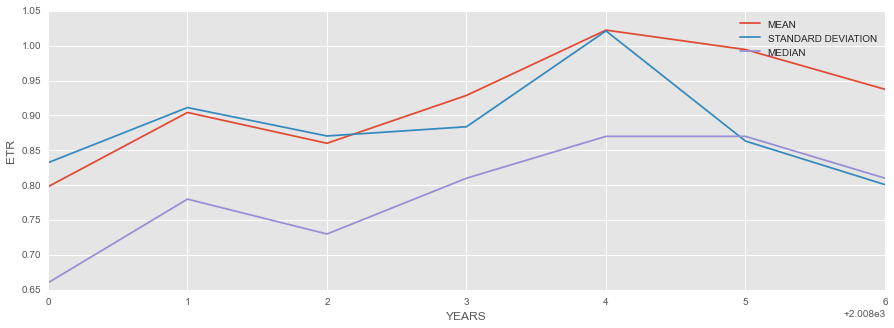

In [56]:
# Plot the response with standard error
#sns.tsplot(data=time, time="SALE_YEAR", unit="ETR_ACTUAL_UNIT_MEAN",
#          value="ETR_ACTUAL_UNIT_STD")
plt.figure(figsize=(15,5))
plt.plot(time.SALE_YEAR,time.ETR_ACTUAL_UNIT_MEAN,label='MEAN')
plt.plot(time.SALE_YEAR,time.ETR_ACTUAL_UNIT_STD,label='STANDARD DEVIATION')
plt.plot(time.SALE_YEAR,time.ETR_ACTUAL_UNIT_MEDIAN,label='MEDIAN')
plt.ylabel('ETR')
plt.xlabel('YEARS')
plt.legend()

The average ETR across the city increased over the years, while the standard deviation decreased. The median ETR did not increase as heavily.

### 7. Analysis of ETR

#### ETR by building class

Building codes explained:
    
http://nycprop.nyc.gov/nycproperty/help/hlpbldgcode.html

http://www.propertyshark.com/mason/text/nyc_building_class.html

***In short: A and B refer to single and two family estates, respectively, while D and R refer to multiple unit buildings. C stands for 3-4 or even 6 family estates.***

In [57]:
# Group by just the different categories, not subcategories
finale.BUILDING_CL = finale.BUILDING_CLASS_AT_TIME_OF_SALE.apply(lambda x: str(x)[:-1])

In [58]:
buildings = pd.DataFrame(
    {'STD_UNIT':finale.groupby([finale.BUILDING_CL,finale.TAX_CLASS_AT_TIME_OF_SALE],axis=0)['ETR_ACTUAL_UNIT'].std(),
    'MEAN_UNIT':finale.groupby([finale.BUILDING_CL,finale.TAX_CLASS_AT_TIME_OF_SALE],axis=0)['ETR_ACTUAL_UNIT'].mean(),
'MEDIAN_UNIT':finale.groupby([finale.BUILDING_CL,finale.TAX_CLASS_AT_TIME_OF_SALE],axis=0)['ETR_ACTUAL_UNIT'].median()}).reset_index()

In [59]:
buildings

,BUILDING_CLASS_AT_TIME_OF_SALE,TAX_CLASS_AT_TIME_OF_SALE,MEAN_UNIT,MEDIAN_UNIT,STD_UNIT
0,A,1,0.759665,0.720,0.446140
1,B,1,0.728760,0.660,0.546707
2,C,1,0.732419,0.610,0.667801
3,C,2,1.219383,0.970,1.223127
4,D,2,1.313350,1.160,0.915473
5,G,1,0.361047,0.255,0.380881
6,R,1,0.370578,0.330,0.365697
7,R,2,0.664411,0.500,0.825413
8,S,1,0.450625,0.370,0.580063
9,S,2,1.008605,0.740,1.158697


***Clearly, throught the last six years, residents of buildings in class C and D paid considerable more in ETR than A and B classes. Not surprisingly, this corresponds to tax class 2 properies.***

## ETR data per zipcode for visualization

In [60]:
ETR_ACTUAL_ZIP = pd.DataFrame({'STD_ETR_ACTUAL':finale.groupby('ZIP_CODE',axis=0)['ETR_ACTUAL_UNIT'].std(),
                            'MEAN_ETR_ACTUAL':finale.groupby('ZIP_CODE',axis=0)['ETR_ACTUAL_UNIT'].mean(),
                            'MEDIAN_ETR_ACTUAL':finale.groupby('ZIP_CODE',axis=0)['ETR_ACTUAL_UNIT'].median()}).reset_index()

In [61]:
def plot(df,color,title,column):
    df = df.merge(zipcodes, on='ZIP_CODE',how='inner')
    df_ = gpd.GeoDataFrame(df)
    df_.crs = {'init': 'epsg:2263'}
    f, ax = plt.subplots(figsize=(12,8));
    ax.set_axis_bgcolor(color);
    plt.grid('off');
    df_.plot(column=column, scheme='QUANTILES', k=7, alpha=0.6, colormap='YlOrRd', axes=ax, legend=True);
    title = title + ' : ' + column.lower()
    #mplleaflet.display(fig=f, crs={'init': 'epsg:2263'},
    #tiles=('http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png','attribution'))
    plt.title(title);

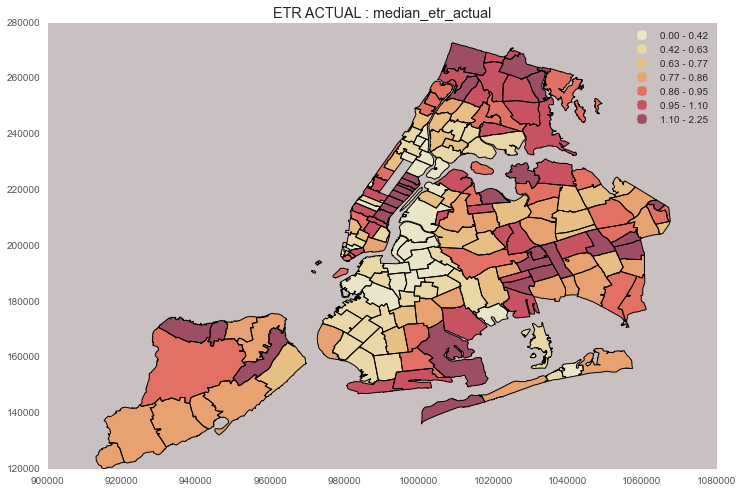

In [62]:
plot(ETR_ACTUAL_ZIP,'#C9C1C1','ETR ACTUAL','MEDIAN_ETR_ACTUAL')

In [63]:
ETR_DOF_ZIP = pd.DataFrame({'STD_ETR_DOF':finale.groupby('ZIP_CODE',axis=0)['ETR_DOF'].std(),
                            'MEAN_ETR_DOF':finale.groupby('ZIP_CODE',axis=0)['ETR_DOF'].mean(),
                'MEDIAN_ETR_DOF':finale.groupby('ZIP_CODE',axis=0)['ETR_DOF'].median()}).reset_index()

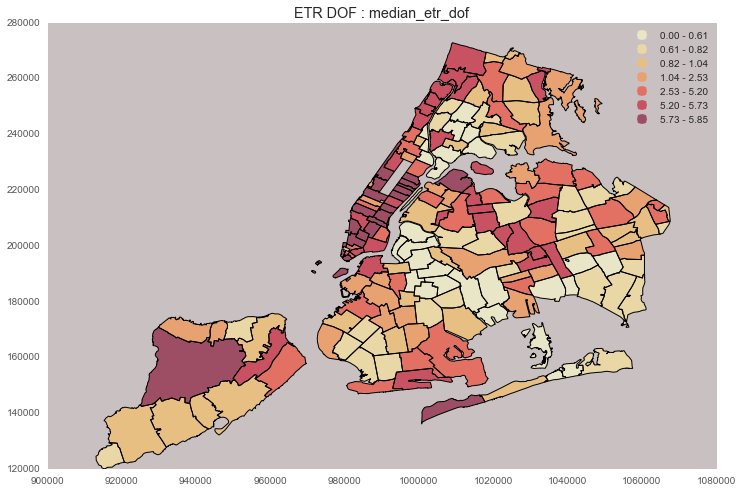

In [64]:
plot(ETR_DOF_ZIP,'#C9C1C1','ETR DOF','MEDIAN_ETR_DOF')

*** Comparing the actual effective tax rates to the tax rates according to the DOF data highlights the discrepancy among residents in different neighbourhoods or zip codes. Parts of the Bronx suffer higher actual tax rates in relative terms than under DOF calculations. DOF data is supposed to burden lower Manhattan and Upper West Side, however, ETRs tell a different story. Also Todt Hill in Staten Island pay less than DOF calculations would suggest.***

In [65]:
# Store ETR data in one summary table
ETR_ZIP = ETR_ACTUAL_ZIP.merge(ETR_DOF_ZIP, on='ZIP_CODE',how='inner')

### As a share of income
***The previous maps showed some relationship between richer neighbourhoods actually paying less and poorer areas actually paying more in effective taxes. Let's investigate this a bit more by creating a burden index.***

In [66]:
# Read income data and merge data
income = pd.read_csv(zip_.open(filename_income))
income.drop(0,inplace=True)
income.rename(columns={'GEO.id2':'ZIP_CODE','HC02_EST_VC02':'MEDIAN_INCOME'},inplace=True)
income = income[['ZIP_CODE','MEDIAN_INCOME']]
income['ZIP_CODE'] = income['ZIP_CODE'].astype(int)

In [67]:
for i in income.MEDIAN_INCOME:
    if i.find('+')!=-1:
        print i

250,000+
250,000+


In [68]:
# Income is capped at 250,000, so tranform median income into numerical data and use cap as maximum value available
income['MEDIAN_INCOME'] = income['MEDIAN_INCOME'].apply(lambda x: x.replace(',','').strip('+').strip())
income['MEDIAN_INCOME'] = np.where(income['MEDIAN_INCOME']=='-',np.nan,income['MEDIAN_INCOME'])
income['MEDIAN_INCOME'] = np.round(income['MEDIAN_INCOME'].astype(float),0)
income = income.dropna()

In [69]:
income.describe()

,ZIP_CODE,MEDIAN_INCOME
count,1710.000000,1710.000000
mean,12748.717544,63800.733918
std,1314.881881,28087.570666
min,6390.000000,10848.000000
25%,11787.250000,45834.250000
50%,12831.500000,56326.500000
75%,13770.500000,75389.000000
max,14905.000000,250000.000000


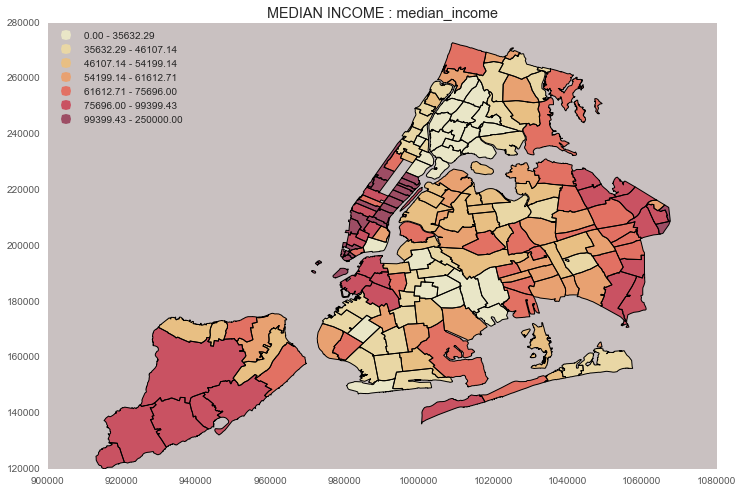

In [70]:
plot(income,'#C9C1C1','MEDIAN INCOME','MEDIAN_INCOME')

In [71]:
PRICE_UNIT_ZIP = pd.DataFrame({'STD_PRICE_UNIT':finale.groupby('ZIP_CODE',axis=0)['SALE_PRICE_UNIT'].std(),
                            'MEAN_PRICE_UNIT':finale.groupby('ZIP_CODE',axis=0)['SALE_PRICE_UNIT'].mean(),
                'MEDIAN_PRICE_UNIT':finale.groupby('ZIP_CODE',axis=0)['SALE_PRICE_UNIT'].median()}).reset_index()

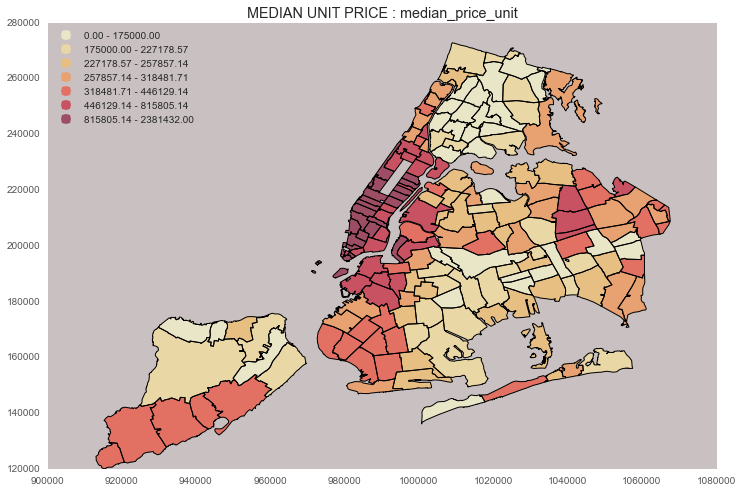

In [72]:
plot(PRICE_UNIT_ZIP,'#C9C1C1','MEDIAN UNIT PRICE','MEDIAN_PRICE_UNIT')

***Not surprisingly, the sale price per unit appears to be highly positively correlated with median income. But what about the actual ETR burden per income group?***

In [73]:
# Create a burden index
# First merge with summary data
PRICE_UNIT_ZIP = PRICE_UNIT_ZIP.merge(income,how='inner',on='ZIP_CODE')
SUMMARY_ZIP = PRICE_UNIT_ZIP.merge(ETR_ZIP,on='ZIP_CODE',how='inner')

***Estimate the median tax burden based on a median income resident buying a median estate unit in a given zip code. Given the data, this is the best overall summary statistic to estimate the burden.***

In [74]:
SUMMARY_ZIP['TAX_BURDEN'] = ((SUMMARY_ZIP['MEDIAN_ETR_ACTUAL']*SUMMARY_ZIP['MEDIAN_PRICE_UNIT'])
                             /SUMMARY_ZIP['MEDIAN_INCOME'])

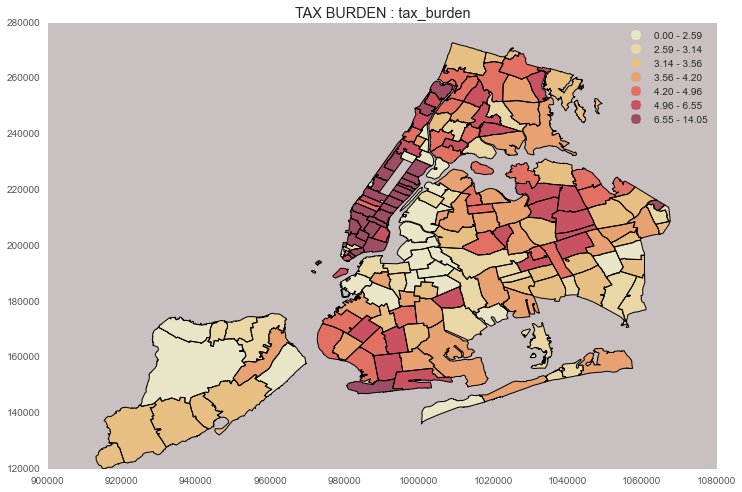

In [75]:
plot(SUMMARY_ZIP,'#C9C1C1','TAX BURDEN','TAX_BURDEN')

***It appears as if the estates in Manhattan are quite overpriced compared to the median income in that neighbourhood. Except from this "obvious" (given that Manhattan has always been historically popular) finding, one exeptional pattern emerges: Parts of the Bronx, West Queens and lower Brooklyn (area around Red Hook) have a higher tax burden than the income and sales price data would suggest.***

### Summaries by Zip Codes

In [76]:
# Get statistics
print 'Mean of Unit Price per tax class',final['SALE_PRICE_UNIT'].groupby(
    final['TAX_CLASS_AT_TIME_OF_SALE']).mean()
print '-----------------------------------------'
print 'Standard Deviation of Unit Price per tax class',final['SALE_PRICE_UNIT'].groupby(
    final['TAX_CLASS_AT_TIME_OF_SALE']).std()

# Get summaries
tax_breakdown = pd.DataFrame({'COUNT':final.groupby(['TAX_CLASS_AT_TIME_OF_SALE',
                                                     'PRICE_BINS'],axis=0).size()}).reset_index()
total_breakdown = pd.DataFrame({'COUNT':final.groupby(['TAX_CLASS_AT_TIME_OF_SALE',
                                                       'PRICE_BINS','ZIP_CODE'],axis=0).size()}).reset_index()
total1 = tax_breakdown[tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==1]['COUNT'].sum()
total2 = tax_breakdown[tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==2]['COUNT'].sum()
tax_breakdown['SHARE'] = np.where(tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==2,
                                  tax_breakdown['COUNT']/total2, tax_breakdown['COUNT']/total1)

PRICE_INFO_ZIP = pd.DataFrame({'COUNT':final.groupby(['ZIP_CODE',
                             'PRICE_UNIT_BINS'],axis=0).size()}).reset_index()
zip_tax_breakdown = pd.DataFrame({'COUNT':final.groupby(['ZIP_CODE',
                                  'TAX_CLASS_AT_TIME_OF_SALE'],axis=0).size()}).reset_index()
total_per_zip = pd.DataFrame({'TOTAL_COUNT':final.groupby(['ZIP_CODE'],axis=0).size()}).reset_index()

# Normalize each count by total sales count and maybe by population
zip_tax_breakdown = zip_tax_breakdown.merge(total_per_zip,on='ZIP_CODE',how='inner')

# Add share of tax class two per zip code, merge it with tax data for tableu.
zip_tax_breakdown['SHARE_CLASS_2'] = zip_tax_breakdown.COUNT/zip_tax_breakdown.TOTAL_COUNT
TAX_INFO_ZIP = zip_tax_breakdown[zip_tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==2]
TAX_INFO_ZIP.drop(['TAX_CLASS_AT_TIME_OF_SALE','COUNT'],axis=1,inplace=True)

# Get price bin info per zip code, without tax class at time of sale
PRICE_INFO_ZIP = TAX_INFO_ZIP.merge(PRICE_INFO_ZIP,on='ZIP_CODE',how='inner')
PRICE_INFO_ZIP['SHARE_PRICE_UNIT_BINS'] = PRICE_INFO_ZIP.COUNT/PRICE_INFO_ZIP.TOTAL_COUNT
PRICE_INFO_ZIP.drop('COUNT',axis=1,inplace=True)
ZIP_INFO = pd.DataFrame(index=np.unique(PRICE_INFO_ZIP.ZIP_CODE.values))

# Create new dataframe that stores the most prevalent price bin present in each zip code
ZIP_INFO['PREVALENT_PRICE_UNIT_BINS_SHARE'] = np.zeros
ZIP_INFO['PREVALENT_PRICE_UNIT_BINS'] = np.zeros
for i in ZIP_INFO.index.values:
    value = PRICE_INFO_ZIP.ix[
        PRICE_INFO_ZIP[PRICE_INFO_ZIP['ZIP_CODE']==i]
        ['SHARE_PRICE_UNIT_BINS'].idxmax()]['SHARE_PRICE_UNIT_BINS']
    bin_info = PRICE_INFO_ZIP.ix[
        PRICE_INFO_ZIP[PRICE_INFO_ZIP['ZIP_CODE']==i]
        ['SHARE_PRICE_UNIT_BINS'].idxmax()]['PRICE_UNIT_BINS']
    ZIP_INFO['PREVALENT_PRICE_UNIT_BINS_SHARE'].iloc[ZIP_INFO.index==i] = value
    ZIP_INFO['PREVALENT_PRICE_UNIT_BINS'].iloc[ZIP_INFO.index==i] = bin_info
ZIP_INFO = ZIP_INFO.reset_index()
ZIP_INFO.rename(columns={'index':'ZIP_CODE'},inplace=True)

# Delete not needed dataframes
del total1
del total2
del total_per_zip
del zip_tax_breakdown

Mean of Unit Price per tax class TAX_CLASS_AT_TIME_OF_SALE
1    421752
2    929308
Name: SALE_PRICE_UNIT, dtype: int64
-----------------------------------------
Standard Deviation of Unit Price per tax class TAX_CLASS_AT_TIME_OF_SALE
1     784896.570263
2    2963245.421521
Name: SALE_PRICE_UNIT, dtype: float64


In [77]:
# Add info
ZIP_INFO = ZIP_INFO.merge(SUMMARY_ZIP,how='inner',on='ZIP_CODE')
ZIP_INFO = ZIP_INFO.merge(TAX_INFO_ZIP,how='inner',on='ZIP_CODE')

In [78]:
# Add quantiles for better visualization, new dataset
ZIP_INFO_Q = ZIP_INFO.copy()
for i in ZIP_INFO_Q.columns:
    if i == 'ZIP_CODE' or i == 'PREVALENT_PRICE_UNIT_BINS':
         ZIP_INFO_Q[i] =  ZIP_INFO_Q[i]
    else:
        m = i+'_BIN'
        k = i+'_LABEL'
        ZIP_INFO_Q[m] = pd.qcut(ZIP_INFO_Q[i],5)
        ZIP_INFO_Q[k] = pd.qcut(ZIP_INFO_Q[i],5,labels=np.arange(1,6))
        del ZIP_INFO_Q[i]

In [79]:
ZIP_INFO_Q.to_csv('ZIP_INFO_Q.csv') # For visualization in Tableau

## Tableau
https://public.tableau.com/shared/H85S34NQC?:display_count=yes

### Investigating TAX 1 and TAX 2 Classes

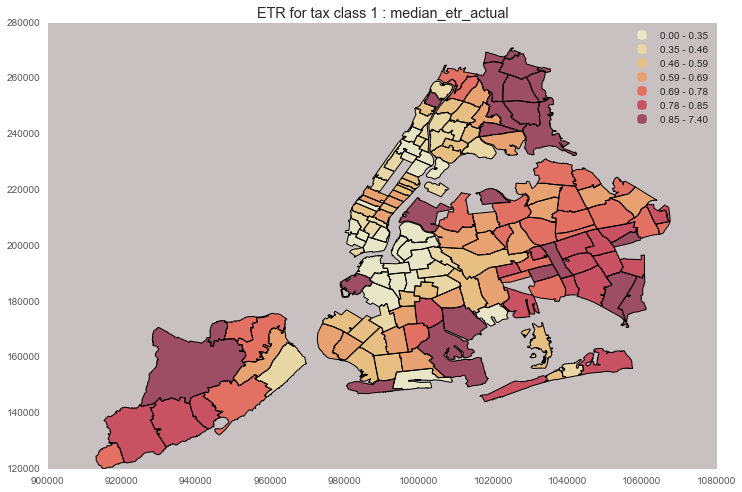

In [80]:
tax1 = finale[finale['TAX_CLASS_AT_TIME_OF_SALE']==1]
# Tax class 1
tax_class_1 = pd.DataFrame({'STD_ETR_ACTUAL':tax1.groupby('ZIP_CODE',axis=0)['ETR_ACTUAL_UNIT'].std(),
                            'MEAN_ETR_ACTUAL':tax1.groupby('ZIP_CODE',axis=0)['ETR_ACTUAL_UNIT'].mean(),
                'MEDIAN_ETR_ACTUAL':tax1.groupby('ZIP_CODE',axis=0)['ETR_ACTUAL_UNIT'].median()}).reset_index()
plot(tax_class_1,'#C9C1C1','ETR for tax class 1','MEDIAN_ETR_ACTUAL')

In [81]:
# Some outliers still exist
len(tax1[tax1.ETR_ACTUAL_UNIT>4])

209

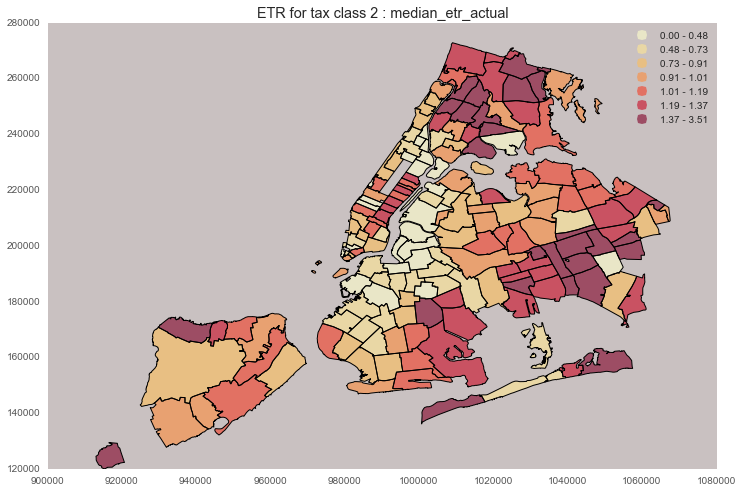

In [82]:
tax2 = finale[finale['TAX_CLASS_AT_TIME_OF_SALE']==2]
# Tax class 2
tax_class_2 = pd.DataFrame({'STD_ETR_ACTUAL':tax2.groupby('ZIP_CODE',axis=0)['ETR_ACTUAL_UNIT'].std(),
                            'MEAN_ETR_ACTUAL':tax2.groupby('ZIP_CODE',axis=0)['ETR_ACTUAL_UNIT'].mean(),
                'MEDIAN_ETR_ACTUAL':tax2.groupby('ZIP_CODE',axis=0)['ETR_ACTUAL_UNIT'].median()}).reset_index()
plot(tax_class_2,'#C9C1C1','ETR for tax class 2','MEDIAN_ETR_ACTUAL')

***Breaking down the two tax classes reinforces the previous finding that the outer boroughs pay relatively more and that poorer neighbourhoods (especially Bronx and Red Hook, but also Southern parts of Brooklyn) pay relatively higher ETR.***

### 8. Analysis of PUMA data

For PUMS map of NYC: 

http://www.nyc.gov/html/dcp/pdf/census/puma_cd_map.pdf

In [83]:
puma = pd.read_csv(zipfile.ZipFile('Zip_spatial/ss14hny.csv.zip').open('ss14hny.csv'))

Data Dictionary: 

http://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2010-2014.txt

Variables to use:
- WGTP: Household weight for generating statistics on housing units and households (such as average household income).
- RNTP 5: Monthly rent
- TEN 1: Tenure (owned/rented/etc.)
- YBL 2: When structure first built
- FINCP 8: Family income (past 12 months)
- GRPIP 3: Gross rent as a percentage of household income past 12 months
- MV 1: When moved into this house or apartment
- TAXP 2: Property taxes (yearly amount)
- BLD 2:Units in structure
- VALP 7: Property value

In [84]:
puma = puma[['WGTP','RNTP','TEN','YBL','FINCP','GRPIP','MV','TAXP','BLD','PUMA','VALP']]
print len(puma)
# One needs consistent data along these dimensions
print len(puma[['YBL','BLD','RNTP','PUMA','VALP']].dropna(subset=['YBL','BLD','RNTP','PUMA','VALP'],how='any'))
puma = puma.dropna(subset=['YBL','BLD','RNTP','PUMA','VALP'],how='any')

92533
81911


In [85]:
# Get the values into the appropriate format
puma.RNTP = puma.RNTP.apply(lambda x: x.lstrip('0').strip())
puma.RNTP = np.where(puma.RNTP=='',np.nan,puma.RNTP)
puma.RNTP = puma.RNTP.astype(float)
puma.GRPIP = puma.GRPIP.apply(lambda x: str(x).lstrip('0').strip())
puma.GRPIP = np.where(puma.GRPIP=='',np.nan,puma.GRPIP)
puma.GRPIP = puma.GRPIP.astype(float)
puma.VALP = puma.VALP.apply(lambda x: str(x).lstrip('0').strip())
puma.VALP = np.where(puma.VALP=='',np.nan,puma.VALP)
puma.VALP = puma.VALP.astype(float)
puma.FINCP = puma.FINCP.apply(lambda x: str(x).lstrip('-').lstrip('0').strip())
puma.FINCP = np.where(puma.FINCP=='',np.nan,puma.FINCP)
puma.FINCP = puma.FINCP.astype(float)

YBL:
When structure first built
- bb .N/A (GQ)
- 01 .1939 or earlier
- 02 .1940 to 1949
- 03 .1950 to 1959
- 04 .1960 to 1969
- 05 .1970 to 1979
- 06 .1980 to 1989
- 07 .1990 to 1999
- 08 .2000 to 2004
- 09 .2005
- 10 .2006
- 11 .2007
- 12 .2008
- 13 .2009
- 14 .2010
- 15 .2011
- 16 .2012
- 17 .2013
- 18 .2014

Get finale building year data in the same structure. In addition, match the BBL of finale data with PUMA codes.

In [86]:
# Create YBL column for sales/assessment data
ybl = pd.Series(np.zeros(len(finale.YEAR_BUILT)))
for i,l in enumerate(finale.YEAR_BUILT):
    if l < 1940:
        ybl[i] = 1
    elif (l>1940) & (l<1950):
        ybl[i] = 2
    elif (l >= 1950) & (l<1960):
        ybl[i] = 3
    elif (l >= 1960) & (l<1970):
        ybl[i] = 4
    elif (l >= 1970) & (l<1980):
        ybl[i] = 5 
    elif (l >= 1980) & (l<1990):
        ybl[i] = 6
    elif (l >= 1990) & (l<2000):
        ybl[i] = 7
    elif (l >= 2000) & (l<2005):
        ybl[i] = 8
    elif l == 2005:
        ybl[i] = 9
    elif l == 2006:
        ybl[i] = 10  
    elif l == 2007:
        ybl[i] = 11
    elif l == 2008:
        ybl[i] = 12
    elif l == 2009:
        ybl[i] = 13
    elif l == 2010:
        ybl[i] = 14
    elif l == 2011:
        ybl[i] = 15
    elif l == 2012:
        ybl[i] = 16
    elif l == 2013:
        ybl[i] = 17
    elif l == 2014:
        ybl[i] = 18 
    else:
        ybl[i] = np.nan

In [87]:
matched = finale.copy()
headers = list(matched.columns)
headers.append('YBL')
headers.append('BLD')

In [88]:
# Add YBL column
matched = pd.concat([matched,ybl],axis=1)

BLD:
Units in structure
- bb .N/A (GQ)
- 01 .Mobile home or trailer
- 02 .One-family house detached
- 03 .One-family house attached
- 04 .2 Apartments
- 05 .3-4 Apartments
- 06 .5-9 Apartments
- 07 .10-19 Apartments
- 08 .20-49 Apartments
- 09 .50 or more apartments
- 10 .Boat, RV, van, etc.

In [89]:
# Create BLD column for sales/assessment data
bld = pd.Series(np.zeros(len(matched.TOT_UNIT)))
for unit,category,pos in zip(matched.TOT_UNIT,matched.BUILDING_CLASS_CATEGORY,range(len(matched.TOT_UNIT))):
    if category == '01  ONE FAMILY DWELLINGS':
        bld[pos] = float(2)
    elif category == '01  ONE FAMILY HOMES':
        bld[pos] = float(3)
    elif (unit==2) & (category != '01  ONE FAMILY DWELLINGS') & (category != '01  ONE FAMILY HOMES'):
        bld[pos] = float(4)
    elif (unit>2)&(category != '01  ONE FAMILY DWELLINGS')&(category != '01  ONE FAMILY HOMES')&(unit<5):
        bld[pos] = float(5)
    elif (unit>=5) & (category != '01  ONE FAMILY DWELLINGS') & (category != '01  ONE FAMILY HOMES') &(unit<10):
        bld[pos] = float(6)
    elif (unit>=10) & (category != '01  ONE FAMILY DWELLINGS') & (category != '01  ONE FAMILY HOMES') &(unit<20):
        bld[pos] = float(7)
    elif (unit>=20) & (category != '01  ONE FAMILY DWELLINGS') & (category != '01  ONE FAMILY HOMES') &(unit<50):
        bld[pos] = float(8)   
    elif (unit>=50) & (category != '01  ONE FAMILY DWELLINGS') & (category != '01  ONE FAMILY HOMES'):
        bld[pos] = float(9) 

In [90]:
# Add BLD column
matched = pd.concat([matched,bld],axis=1)
matched.columns = headers

In [91]:
# Add puma-bbl info to matched dataset
puma_loc = pd.read_csv('ZIP_spatial/taxlots_with_PUMA.csv')
del puma_loc['Unnamed: 0']
print (len(matched))
matched = matched.merge(puma_loc,on='BBL',how='inner')
print (len(matched)) # Check how many observations are omitted

252729
172503


In [92]:
# Cut building values into the same bins as for sales data
puma['VALP_BINS'] = pd.cut(puma.VALP,bins,labels=labels)
# Group rent by the dimensions
puma_breakdown = pd.DataFrame({'MEDIAN':puma.groupby(['VALP_BINS','PUMA','BLD','YBL'],axis=0)['RNTP'].mean()}).reset_index()

In [93]:
# Why is the median rent NaN?
puma_breakdown.head()

,VALP_BINS,PUMA,BLD,YBL,MEDIAN
0,1,100,1,3,NaN
1,1,100,1,4,NaN
2,1,100,1,5,NaN
3,1,100,1,6,NaN
4,1,100,1,7,NaN


In [94]:
# Seems like if rent is recorded, the value of the building is not, and vice versa. 
# This means that when rent is available, surveyed people are tenants and not homeowners
# Same goes for TAXP
puma.head(5)

,WGTP,RNTP,TEN,YBL,FINCP,GRPIP,MV,TAXP,BLD,PUMA,VALP,VALP_BINS
0,631,NaN,1,5,NaN,NaN,4,21,8,3808,500000,3
2,183,1300,3,4,76200,20,5,NaN,9,3107,NaN,NaN
3,59,1300,3,5,98200,17,5,NaN,9,4103,NaN,NaN
4,36,NaN,NaN,1,NaN,NaN,NaN,NaN,2,100,NaN,NaN
6,37,NaN,2,3,47100,NaN,7,1,2,1500,99000,1


***The above finding won't allow to establish as link between the market value of a building in the puma data and assessment/sales data, because this would only apply to homeowners. Let's proceed with a less strong probabilistic link of rent and sales/assessment data for tenants, but prepare a model for homeowners as well.***

### Home owners

In [95]:
# Get counts per bins
counts = pd.DataFrame({'COUNT':puma.groupby(['VALP_BINS','PUMA','BLD','YBL'],axis=0).size()}).reset_index()
# Get total counts per puma
total_counts = pd.DataFrame({'TOT_COUNT':puma.groupby(['PUMA','BLD','YBL'],axis=0).size()}).reset_index()
# Merge the two
puma_breakdown = total_counts.merge(counts,on=['PUMA','BLD','YBL'], how='inner')
puma_breakdown['SHARE_VALP_BINS'] = puma_breakdown.COUNT/puma_breakdown.TOT_COUNT
# Get the price bin that is most prelavent, thus has the most likely probability
maximum_count = pd.DataFrame({'SHARE_VALP_BINS':puma_breakdown.groupby(['PUMA','BLD',
                              'YBL'],axis=0)['SHARE_VALP_BINS'].max()}).reset_index()
totals = maximum_count.merge(puma_breakdown[['PUMA','BLD','YBL','VALP_BINS','SHARE_VALP_BINS']],
                                  on=['PUMA','BLD','YBL','SHARE_VALP_BINS'],how='inner')
totals.rename(columns={'VALP_BINS':'PREVALENT_VALP_BINS'},inplace=True)

#### VALP data could be based on the DOF assessment or actual market value. For this reason, both possibilities are investigated.
To compare sales data, compute approximate market value of the whole building: SALE_PRICE_UNIT * TOT_UNIT

To compare to assessment data, just take: CUR_FV_T

But PUMS data is from 2014 so lag data and take sale/assessment data from 2013.

In [96]:
def trim_fraction(text):
    if '.0' in text:
        return text[:text.rfind('.0')]
    return text
def pickyear(df,y):
    df_ = df[df.SALE_YEAR==y]
    df_['MKT_VALUE'] = df_.SALE_PRICE_UNIT*df_.TOT_UNIT
    df_['PREVALENT_VALP_BINS'] = pd.cut(df_.MKT_VALUE,bins,labels=labels)
    df_.PUMA = df_.PUMA.astype(str)
    df_.PUMA = df_.PUMA.apply(trim_fraction)
    df_ = df_.reset_index()
    del df_['index']
    return df_

In [97]:
# Create info summary table for puma, to be merged with sales/assessment data
info = pd.DataFrame({'FINCP_MEDIAN':puma.groupby(['PUMA','BLD','YBL','VALP_BINS'],axis=0)['FINCP'].median(),
                    'FINCP_MEAN':puma.groupby(['PUMA','BLD','YBL','VALP_BINS'],axis=0)['FINCP'].mean(),
                'TAXP_MEDIAN':puma.groupby(['PUMA','BLD','YBL','VALP_BINS'],axis=0)['TAXP'].median(),          
                'TAXP_MEAN':puma.groupby(['PUMA','BLD','YBL','VALP_BINS'],axis=0)['TAXP'].mean(),
                   'GRPIP_MEDIAN':puma.groupby(['PUMA','BLD','YBL','VALP_BINS'],axis=0)['GRPIP'].median(),
                   'GRPIP_MEAN':puma.groupby(['PUMA','BLD','YBL','VALP_BINS'],axis=0)['GRPIP'].mean(),
                   'TEN_MEDIAN':puma.groupby(['PUMA','BLD','YBL','VALP_BINS'],axis=0)['TEN'].median(),
                   'TEN_MEAN':puma.groupby(['PUMA','BLD','YBL','VALP_BINS'],axis=0)['TEN'].mean()
                   }).reset_index()
info.rename(columns={'VALP_BINS':'PREVALENT_VALP_BINS'},inplace=True)
# Merge it with info on pumas and bins
info_per_puma = totals.merge(info,on=['PUMA','BLD','YBL','PREVALENT_VALP_BINS'],how='inner')
info_per_puma.PUMA = info_per_puma.PUMA.astype(str)

In [98]:
# Prepare for merger with assessment/sales data
matched2014 = pickyear(matched,2013) # To lag

In [99]:
# Based on approximate market value
print len(matched2014.merge(info_per_puma,on=['PUMA','YBL','BLD','PREVALENT_VALP_BINS'],how='inner'))
matched2014['PREVALENT_VALP_BINS'] = pd.cut(matched2014.CUR_FV_T,bins,labels=labels)
puma_dof = matched2014.merge(info_per_puma,on=['PUMA','YBL','BLD','PREVALENT_VALP_BINS'],how='inner')
print len(puma_dof)

4637
5351


DOF data seems to match the responses of the surveys more often than the actual approximate market value,
thus in further analysis I will stick to DOF data as a merger criterion.

### Implications
***Using aggregate puma data for homeowners does not reveal statistical significant relationship between the most prevalent price bin in a given puma district and the median effective tax rate paid within the same area.***

### Renters
***Because of the previous limitation of available market value estimates and rent for the same property, it is not possible to link similar buildings on the previous four dimensions (price, building type and age, PUMA).
The data on rents cannot be extrapolated to estimate the market value of the building, since the exact number of units within the survey participant's building is unknown.
To estimate the association between ETR and rents, only BLD,YBL and PUMA can be used, which severly limits the explanatory value of the model.*** 

In [100]:
# Let's aggregate the data on a puma level:
matched2014_aggregated = pd.DataFrame({
        'ETR_ACTUAL_MEDIAN': matched2014.groupby(['PUMA','BLD',
        'YBL'],axis=0)['ETR_ACTUAL_UNIT'].median(),
        'ETR_ACTUAL_MEAN': matched2014.groupby(['PUMA','BLD',
        'YBL'],axis=0)['ETR_ACTUAL_UNIT'].mean(),
        'ETR_DOF_MEDIAN': matched2014.groupby(['PUMA','BLD',
        'YBL'],axis=0)['ETR_DOF'].median(),
        'ETR_DOF_MEAN': matched2014.groupby(['PUMA','BLD',
        'YBL'],axis=0)['ETR_DOF'].mean(),
        'PRICE_UNIT_BINS_MEDIAN': matched2014.groupby(['PUMA','BLD',
        'YBL'],axis=0)['PRICE_UNIT_BINS'].median(),
        'PRICE_UNIT_BINS_MEAN': matched2014.groupby(['PUMA','BLD',
        'YBL'],axis=0)['PRICE_UNIT_BINS'].mean(),
    }).reset_index()

In [101]:
# Create info summary table for puma, to be merged with sales/assessment data
info = pd.DataFrame({'RNTP_MEDIAN':puma.groupby(['PUMA','BLD','YBL'],axis=0)['RNTP'].median(),
                    'RNTP_MEAN':puma.groupby(['PUMA','BLD','YBL'],axis=0)['RNTP'].mean(),
                    'FINCP_MEDIAN':puma.groupby(['PUMA','BLD','YBL'],axis=0)['FINCP'].median(),
                    'FINCP_MEAN':puma.groupby(['PUMA','BLD','YBL'],axis=0)['FINCP'].mean(),
                'TAXP_MEDIAN':puma.groupby(['PUMA','BLD','YBL'],axis=0)['TAXP'].median(),          
                'TAXP_MEAN':puma.groupby(['PUMA','BLD','YBL'],axis=0)['TAXP'].mean(),
                   'GRPIP_MEDIAN':puma.groupby(['PUMA','BLD','YBL'],axis=0)['GRPIP'].median(),
                   'GRPIP_MEAN':puma.groupby(['PUMA','BLD','YBL'],axis=0)['GRPIP'].mean(),
                   'TEN_MEDIAN':puma.groupby(['PUMA','BLD','YBL'],axis=0)['TEN'].median(),
                   'TEN_MEAN':puma.groupby(['PUMA','BLD','YBL'],axis=0)['TEN'].mean()
                   }).reset_index()
# Merge it with info on pumas and bins
info.PUMA = info.PUMA.astype(str)


In [102]:
# For estimation purposes
def tonumeric(df,col):
    df[col] = df[col].astype(float)

In [103]:
tonumeric(matched2014_aggregated,['PUMA','YBL','BLD'])
tonumeric(puma,['PUMA','YBL','BLD'])

In [104]:
matched2014_rents = matched2014_aggregated.merge(puma,on=['PUMA','YBL','BLD'],how='inner')

In [105]:
matched2014_rents.head()

,PUMA,BLD,YBL,ETR_ACTUAL_MEAN,ETR_ACTUAL_MEDIAN,ETR_DOF_MEAN,ETR_DOF_MEDIAN,PRICE_UNIT_BINS_MEAN,PRICE_UNIT_BINS_MEDIAN,WGTP,RNTP,TEN,FINCP,GRPIP,MV,TAXP,VALP,VALP_BINS
0,3701,2,1,1.245385,1.03,0.73,0.75,1.846154,2,108,NaN,1,33400,NaN,5,28,400000,2
1,3701,2,1,1.245385,1.03,0.73,0.75,1.846154,2,128,NaN,1,NaN,NaN,7,68,2650000,7
2,3701,2,1,1.245385,1.03,0.73,0.75,1.846154,2,48,NaN,1,60960,NaN,4,36,320000,2
3,3701,2,1,1.245385,1.03,0.73,0.75,1.846154,2,74,NaN,2,107560,NaN,5,68,2800000,7
4,3701,2,1,1.245385,1.03,0.73,0.75,1.846154,2,55,NaN,2,NaN,NaN,5,64,700000,4


In [106]:
tonumeric(matched2014_rents,['TEN','YBL','BLD','PUMA'])
puma_model_tenants = smf.ols(formula='''GRPIP ~ ETR_ACTUAL_MEDIAN + C(TEN)
                                 ''',
                                data=matched2014_rents).fit()
print puma_model_tenants.summary()

                            OLS Regression Results                            
Dep. Variable:                  GRPIP   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   -0.2623
Date:                Thu, 10 Mar 2016   Prob (F-statistic):               1.00
Time:                        16:10:27   Log-Likelihood:                -45518.
No. Observations:                9470   AIC:                         9.104e+04
Df Residuals:                    9467   BIC:                         9.106e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept         -5.398e+12   2.94e+1

## 9. Zillow data

http://www.zillow.com/research/data/

http://www.zillow.com/research/zillow-rent-index-methodology-2393/

In [107]:
import urllib2
url = 'http://files.zillowstatic.com/research/public/Zip/Zip_Zri_SingleFamilyResidenceRental.csv'
url1 = 'http://files.zillowstatic.com/research/public/Zip/Zip_ZriPerSqft_AllHomes.csv'
url2 = 'http://files.zillowstatic.com/research/public/Zip/Zip_Zri_MultiFamilyResidenceRental.csv'

def set(url):
    file_ = urllib2.urlopen(url)
    name = pd.read_csv(file_)
    name = name[name.City=='New York']
    return name

In [108]:
one_family = set(url)
all_homes = set(url1)
multi_family = set(url2)

In [109]:
all_homes.rename(columns={'RegionName':'ZIP_CODE'},inplace=True)

In [110]:
# Set columns
info2015 = list(all_homes.columns[-13:-1])
info2015.append('ZIP_CODE')
info2014 = list(all_homes.columns[-25:-13])
info2014.append('ZIP_CODE')
info2013 = list(all_homes.columns[-37:-25])
info2013.append('ZIP_CODE')
info2012 = list(all_homes.columns[-49:-37])
info2012.append('ZIP_CODE')
info2011 = list(all_homes.columns[-61:-49])
info2011.append('ZIP_CODE')
info2010 = list(all_homes.columns[-63:-61])
info2010.append('ZIP_CODE')

# Set data
z2015 = all_homes[info2015]
z2014 = all_homes[info2014]
z2013 = all_homes[info2013]
z2012 = all_homes[info2012]
z2011 = all_homes[info2011]
z2010 = all_homes[info2010]

# Add mean score
z2015['MEAN_ZILLOW_SCORE'] = z2015[info2015[:-1]].mean(axis=1)
z2014['MEAN_ZILLOW_SCORE'] = z2014[info2014[:-1]].mean(axis=1)
z2013['MEAN_ZILLOW_SCORE'] = z2013[info2013[:-1]].mean(axis=1)
z2012['MEAN_ZILLOW_SCORE'] = z2012[info2012[:-1]].mean(axis=1)
z2011['MEAN_ZILLOW_SCORE'] = z2011[info2011[:-1]].mean(axis=1)
z2010['MEAN_ZILLOW_SCORE'] = z2010[info2010[:-1]].mean(axis=1)

# Select only summary columns
z2015 = z2015[list(z2015.columns[-2:])]
z2014 = z2014[list(z2014.columns[-2:])]
z2013 = z2013[list(z2013.columns[-2:])]
z2012 = z2012[list(z2012.columns[-2:])]
z2011 = z2011[list(z2011.columns[-2:])]
z2010 = z2010[list(z2010.columns[-2:])]

#### Merge data

In [111]:
zillow = finale.copy()
# Break zillow back into the different sales years to merge with correct rent data
y2014 = (zillow[zillow['SALE_YEAR']==2014])
y2013 = (zillow[zillow['SALE_YEAR']==2013])
y2012 = (zillow[zillow['SALE_YEAR']==2012])
y2011 = (zillow[zillow['SALE_YEAR']==2011])
y2010 = (zillow[zillow['SALE_YEAR']==2010])
y2009 = (zillow[zillow['SALE_YEAR']==2009])
y2008 = (zillow[zillow['SALE_YEAR']==2008])
# Lag the data by one year, to somewhat capture the possible effects
y2014 = y2014.merge(z2015,on='ZIP_CODE',how='inner')
y2013 = y2013.merge(z2014,on='ZIP_CODE',how='inner')
y2012 = y2012.merge(z2013,on='ZIP_CODE',how='inner')
y2011 = y2011.merge(z2012,on='ZIP_CODE',how='inner')
y2010 = y2010.merge(z2011,on='ZIP_CODE',how='inner')
y2009 = y2009.merge(z2010,on='ZIP_CODE',how='inner')

In [112]:
zillow = y2014.append([y2013,y2012,y2011,y2010,y2009])

In [113]:
info_zillow = pd.DataFrame({'MEAN_ZILLOW_SCORE':zillow.groupby('ZIP_CODE',
                                                               axis=0)['MEAN_ZILLOW_SCORE'].median()}).reset_index()
info_zillow = info_zillow.merge(ZIP_INFO,on='ZIP_CODE',how='inner')
info_zillow.ZIP_CODE = info_zillow.ZIP_CODE.astype(str)
info_zillow.PREVALENT_PRICE_UNIT_BINS = info_zillow.PREVALENT_PRICE_UNIT_BINS.astype(str)

In [114]:
info_zillow[['PREVALENT_PRICE_UNIT_BINS','MEDIAN_PRICE_UNIT','MEDIAN_INCOME',
      'MEDIAN_ETR_ACTUAL','SHARE_CLASS_2','MEAN_ZILLOW_SCORE']].corr()

,MEDIAN_PRICE_UNIT,MEDIAN_INCOME,MEDIAN_ETR_ACTUAL,SHARE_CLASS_2,MEAN_ZILLOW_SCORE
MEDIAN_PRICE_UNIT,1.000000,0.751053,-0.191212,0.684291,0.838427
MEDIAN_INCOME,0.751053,1.000000,0.130611,0.335916,0.589872
MEDIAN_ETR_ACTUAL,-0.191212,0.130611,1.000000,-0.237770,-0.100648
SHARE_CLASS_2,0.684291,0.335916,-0.237770,1.000000,0.784203
MEAN_ZILLOW_SCORE,0.838427,0.589872,-0.100648,0.784203,1.000000


In [115]:
model = smf.ols(formula='''MEAN_ZILLOW_SCORE ~ C(PREVALENT_PRICE_UNIT_BINS)+
                 MEDIAN_ETR_ACTUAL + SHARE_CLASS_2''',data=info_zillow).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:      MEAN_ZILLOW_SCORE   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     95.91
Date:                Thu, 10 Mar 2016   Prob (F-statistic):           2.20e-51
Time:                        16:10:56   Log-Likelihood:                -102.28
No. Observations:                 154   AIC:                             220.6
Df Residuals:                     146   BIC:                             244.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------
In

In [116]:
### Save datasets
info_zillow.to_pickle('INFO_ZILLOW')
matched2014_rents.to_pickle('INFO_PUMA')
finale.to_pickle('FINAL')

## 10. Visualizations

In [117]:
price_bins = pd.DataFrame({'COUNT':finale.groupby(['SALE_YEAR','PRICE_UNIT_BINS']
                                                               ,axis=0)['BBL'].size()}).reset_index()

In [118]:
price_bins[:4]

,SALE_YEAR,PRICE_UNIT_BINS,COUNT
0,2008,1,7373
1,2008,2,11833
2,2008,3,6824
3,2008,4,4049


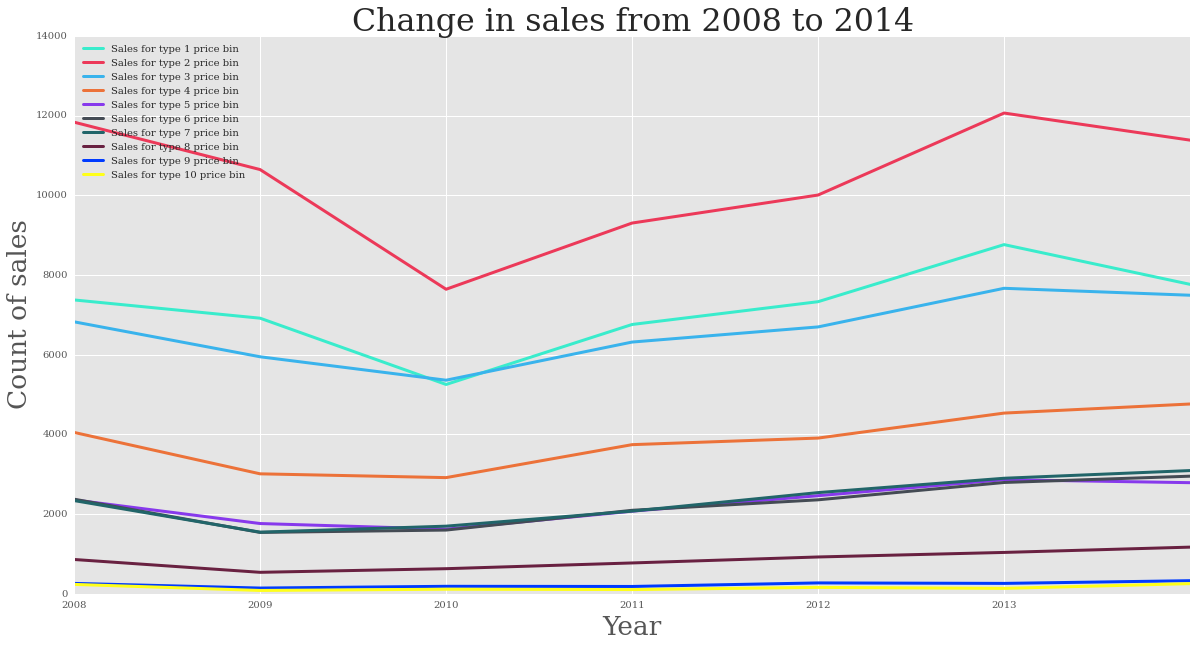

In [127]:
import matplotlib as mpl
font = {'family' : 'serif',
        'weight' : 'light',
        'size'   : 22}
mpl.rcParams['axes.color_cycle'] = ['#39eccc','#ec3959','#39b3ec','#ec7239','#8739ec',
                                    '#444b54','#216569','#692141','#003BFF','#FFFF1A']
plt.rc('font', **font)
plt.figure(figsize=(20,10))
colors 
ax = fig.add_subplot(111, axisbg='#ffffff')
for i in np.unique(price_bins['PRICE_UNIT_BINS'].values):
    x = price_bins[price_bins['PRICE_UNIT_BINS']==i]['SALE_YEAR']
    y = price_bins[price_bins['PRICE_UNIT_BINS']==i]['COUNT']
    plt.plot(x,y,label='Sales for type %s price bin'%(i),linewidth=3)
    #plt.fill_between(x,y,0,alpha=(int(i)))
    ax.get_xaxis().tick_bottom()
    locs, labels = plt.xticks()
    ticks = np.arange(2008, 2014, 1)
    ticks = [str(ticks[i]) for i in range(len(ticks))]
    plt.xticks(np.arange(2008, 2014, 1),ticks)#('2008','2010','2012','2014'))
    plt.title('Change in sales from 2008 to 2014')
    plt.ylabel('Count of sales')
    plt.xlabel('Year')
    plt.legend(loc='upper left')

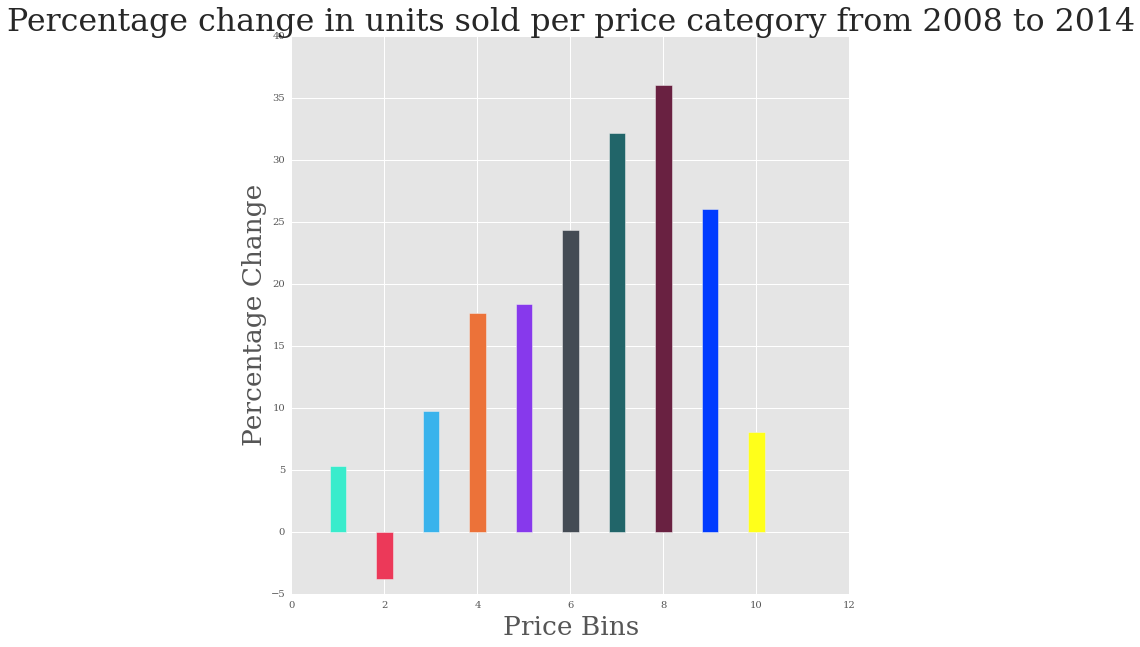

In [128]:
colors = ['#39eccc','#ec3959','#39b3ec','#ec7239','#8739ec',
          '#444b54','#216569','#692141','#003BFF','#FFFF1A']
width = 0.35
fig,ax = plt.subplots(figsize=(10,10))
#ax = fig.add_subplot(111)
for i in np.unique(price_bins['PRICE_UNIT_BINS'].values):
    t1 = float(price_bins[(price_bins['PRICE_UNIT_BINS']==i)&(price_bins['SALE_YEAR']==2008)]['COUNT'])
    t2 = float(price_bins[(price_bins['PRICE_UNIT_BINS']==i)&(price_bins['SALE_YEAR']==2014)]['COUNT'])
    ax.bar((i-(width)/2), ((t2-t1)/t1)*100, width, color=colors[i-1]) 
    ax.get_xaxis().tick_bottom()
    locs, labels = plt.xticks()
    ticks = np.arange(1, 10, 2)
    ticks = [str(ticks[i]) for i in range(len(ticks))]
plt.xlabel('Price Bins')
plt.ylabel('Percentage Change')
plt.title('Percentage change in units sold per price category from 2008 to 2014')